# Dealing with limited data for semantic segmentation
> Strategies for efficiently collecting more data to target specific areas of underperforming models and techniques to adopt to maximize utility of the data



After we have evaluated how well a model has performed, we do one of two things:

1. decide we are happy with how the model has performed on the validation set, and report the model performance on the test set (and validation set). Hooray!
2. Diagnose issues with our model in terms of false positives or false negatives and make a plan for improving performance on classes that are underperforming.

One of the most fundamental and high impact practices to improve model performance, particularly with deep learning, is to increase the overall size of the training dataset, focusing on classes that are underperforming. However, in remote sensing it is difficult and time consuming to acquire high quality training data labels, particularly compared to other domains where computer vision and machine learning techniques are used.

Because of this unique difficulty when annotating geospatial imagery, we need to do two things:
1. closely inspect our original labeled dataset for quality issues, such as mismatch with the imagery due to date, incorrect class labels, and incorrect label boundaries
2. weigh the cost and benefits of annotating new labels or try other approaches to maximize our model's performance with the data we already have.

Part 1 of this Lesson will describe considerations for setting up an annotation campaign, keeping in mind data quality issues.

Part 2 will cover techniques for maximizing the performance of models trained with limited data, assuming label quality is sufficient.

## Specific concepts that will be covered

Part 1:
* How to decide on a class hierarchy prior to an annotation campaign and what inputs should be made available to an annotator
* How to efficiently annotate geospatial imagery for semantic segmentation (pixel-wise classification)
* When it makes sense to annotate for instance segmentation (predictions are vectors) instead of semantic segmentation (predictions are rasters)
* Choosing a sampling strategy that represents classes of interest

Part 2:
* Transfer Learning from pretrained models.  We'll use a pretrained U-net with a Mobilenet backbone model as an example.
* Data augmentation, or multiplying your training data with image transforms

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts.

**Time Estimated**: 60-120 min

# Part 1: Setting up an Annotation Campaign

## Deciding what classes to annotate and what imagery to use as a basemap

Annotating objects of interest in remotely sensed imagery is particularly challenging. Satellite images can be difficult to interpret and may require domain knowledge/training to annotate. The imagery that is best suited for annotation may not be in RGB format. And boundaries of the object of interest may be very complex or even mixed with surrounding pixels.

:::{figure-md} Sundarbans-fig
<img src="https://miro.medium.com/max/436/1*pN8_LyZtq8-6AsY_tzSjqQ.png" width="450px">

 A flooded forest in Sundarbans National Park, India [https://towardsdatascience.com/land-cover-classification-in-satellite-imagery-using-python-ae39dbf2929).
:::

The example above, a mangrove in Sundarban National Park, India, illustrates many of these difficulties. While rivers have relatively clear cut boundaries, flooded zones in the center of the image are more complex, with many dfferent land cover types mixed together in a close setting. When looking at the image on the left, some considerations for setting up an annotation would be:

* how many classes should there be?
    - we should identify common classes that are well represented in our imagery and that we care about
    - we can lump classes in with the background class if they are 1) rare and 2) they are not of interest. However, if we find with our models that a class of interest is confused with a rare class that we don't care about, it might be worth annotating this class in order to more holistically test our model's performance
    - if we are primarily interested in mapping flooded forest, we might prioritize mapping flooded forest zones as a whole (ignoring microscale differences in cover, such as areas with slightly more canopy). It may also be a good idea to annotate rivers since this class could be easily confused with flooded areas.
* how specific should these classes be?
    - there's always an ideal set of classes we wish we could map and then there is what is possible with the data available
    - some classes we wish to separate may be too spectrally similar with the data available to us
    - a good example of this in the image above might be two different species of mangroves. With Landsat, Sentinel-2, or Planet imagery, we would not be able to map species level differences in naturally occurring mangrove trees.
* phrased another way, is there a spectral or textural signal in the satellite imagery that annotators can see when annotating?
    - if there's no signal, we either need to procure a better imagery source or refine the classes to make them more general to accomodate data limitations
    - if there is a textural signal used in the modeling approach, the groundtruth data needs to be created as polygons, not points. Point-based reference data does not capture textural information and can only be used to train general-purpose machine learning algorithms like Random Forest or densely connected neural networks. CNNs require groundtruth data to be annotated as polygons.
*  what is the timestamp of the image? all labels need to have the correct timestamp metadata that corresponds to the imag eused for annotation.
    * this helps us consider what time periods the ML model was trained on and also when these labels are relevant. if the modeling approach needs to incorporate time series data, the labels must have timestamps to develop the model.


## Tips for efficiently annotating geospatial imagery for semantic segmentation (pixel-wise classification)

An additional consideration for an annotation campaign is, can our annotators accurately and efficiently annotate the classes we prioritize. Let's consider the following example, where want to map urban tree cover, buildings, and parking lots.

:::{figure-md} LULC Labeling
<img src="https://github.com/developmentseed/tensorflow-eo-training/blob/main/ds_book/docs/images/lulc_labeling.gif?raw=1" width="450px">

Our Data Team labeling segments in a complex scene using JOSM, the Java Open Street Map Editor.
:::

LULC classes are often directly adjacent to each other. Therefore, it can be very helpful to annotate in a platform that supports snapping edges to existing annotations and editing both in tandem, as the gif demonstrates. The background class does not need to be annotated manually.

It's also a good practice to time annotators to see how long they take to map a given area, in order to assess the cost and benefit of annotating a set of classes. This can help you decide if you need to divide an area into smaller tasks for multiple annotators to work together to finish annotating an AOI.

Annotations should be reviewed by some supervisor/expert that can assess quality, diagnose issues, and work with annotators to incorporate their feedback, possibly adjusting the task or improving instruction given to annotators ahead of the annotation task

## When it makes sense to annotate for instance segmentation (predictions are vectors) instead of semantic segmentation (predictions are rasters)

The output of U-nets and other semantic segmentation models tell you the class probability (or a set of class probabilities) at a single pixel. If you're interested in estiamting total area of parking lots, or knowing all the locations of parking lot pixels, semantic segmentation will suffice.

However, if you'd like to count parking lots (or agricultural fields or mines) and know the location and extent of individiual parking lots, an instance segmentation approach is required. The output of an instance segmentation approach tells you the class probabilities at each pixel as well as the object membership of a pixel.

There are many ways to get to an instance segmentation output. Some deep learning models, such as Mask R-CNN, train a model end-to-end to take raster inputs and return instance segmentation outputs (which can be thought of as vectors or polygon coordinates). Another approach is to post-process the results from a semantic segmentation model to delineate polygon boundaries from a map of class probabilities or class ids.

### Choosing a sampling strategy that represents classes of interest

Detection problems in remote sensing are unique because oftentimes we are dealing with very large, megapizxel images, but small objects of interest. Because of this, it is important to sample our annotation areas so that we capture many examples of the classes we care about detecting. A simple random sample of tiles within an AOI is most likely not the correct approach here, as it would undersample our classes of interest and lead to class imbalance.

An example of this challenge is marine debris detection with Planet Labs imagery.

:::{figure-md} Marine Debris Detection with Planet Labs
<img src="https://github.com/developmentseed/tensorflow-eo-training/blob/main/ds_book/docs/images/marine_debris.png?raw=1" width="450px">

An annotated Planet Labs image containing marine plastic pollution.
:::

In this case, Lilly's AOI was the entire ocean. a simple random sample of the whole ocean, or even all coastlines or major currents, would result in an overhelming amount of the background class. Instead annotation areas were targeted based on geolocated reports of marine debris. An approach DevSeed uses in a lot of projects is to try to develop as many represnetative sampels of the main class of interest as possible, and additionally develop representative samples of hard negatives (which look like the class of interest). We then control the amount of "easy negatives" that are introduced in the training set so that we minimize class imbalance.

## Part 2: Limited Data Techniques

We'll shift gears now to learning techniques for magnifying the impact of the data that we already have, assuming that we've considered all the questions above. To start with, we'll make sure we have our libraires installed and imported.

In [ ]:
# install required libraries
!pip install -q -U tfds-nightly
!pip install -q focal-loss==0.0.7
#!pip install -q matplotlib==3.5 # UNCOMMENT if running on LOCAL
!pip install -q scikit-learn==1.2.2
!pip install -q scikit-image==0.19.3
!pip install -U -q segmentation-models==1.0.1
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
!pip install -q albumentations==1.2.1

In [ ]:
# import required libraries
import os, functools
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

import pandas as pd
import skimage.io as skio

from IPython.display import clear_output

import segmentation_models as sm
from focal_loss import SparseCategoricalFocalLoss

from albumentations import (
    Compose, Blur, HorizontalFlip, VerticalFlip,
    Rotate, ChannelShuffle
)

# set your folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    processed_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-processed-outputs/'
    user_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-user_outputs_dir'
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
    print('Running on Colab')
else:
    processed_outputs_dir = os.path.abspath("./data/tf-eo-devseed-processed-outputs")
    user_outputs_dir = os.path.abspath('./tf-eo-devseed-user_outputs_dir')
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
        os.makedirs(processed_outputs_dir)
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(processed_outputs_dir)}')

img_dir = os.path.join(processed_outputs_dir,'rasters/tiled/stacks_brightened/') # or os.path.join(processed_outputs_dir,'rasters/tiled/indices/') if using the indices
label_dir = os.path.join(processed_outputs_dir,'rasters/tiled/labels/')

In [ ]:
# Move to your user directory in order to write data
%cd $user_outputs_dir

### Enabling GPU

This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

### Check out the labels

In [ ]:
# Read the classes

data = {'class_names':  ['Background', 'Wheat', 'Rye', 'Barley', 'Oats', 'Corn', 'Oil Seeds', 'Root Crops', 'Meadows', 'Forage Crops'],
        'class_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        }

classes = pd.DataFrame(data)
print(classes)

    class_names  class_ids
0    Background          0
1         Wheat          1
2           Rye          2
3        Barley          3
4          Oats          4
5          Corn          5
6     Oil Seeds          6
7    Root Crops          7
8       Meadows          8
9  Forage Crops          9


In [ ]:
train_df = pd.read_csv(os.path.join(user_outputs_dir, "train_file_paths.csv"))
validate_df =  pd.read_csv(os.path.join(user_outputs_dir, "validate_file_paths.csv"))
test_df =  pd.read_csv(os.path.join(user_outputs_dir, "test_file_paths.csv"))

In [ ]:
x_train_filenames = train_df["img_names"]
y_train_filenames = train_df["label_names"]
x_val_filenames = validate_df["img_names"]
y_val_filenames = validate_df["label_names"]
x_test_filenames = test_df["img_names"]
y_test_filenames = test_df["label_names"]

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

### Setting up our Augmentations

[albumentations](https://albumentations.ai/docs/examples/tensorflow-example/) is a library that contains hundreds of options for transforming images to multiply your training dataset. While each additional image may not be as additively valuable as independent samples, showing your model harder to classify copies of your existing samples can help improve your model's ability to generalize. Plus, augmentations are basically free training data!

Common augmentations include brightening images, applying blur, saturation, flipping, rotating, and randomly cropping and resizing. We'll apply a few augmentations from the `albumentations` library to highlight how to set up an augmentation pipeline. This differs from coding your own augmentations, like we did in episode 3 with our horizontal flip and veritcal flip functions, saving time and lines of code.

In [ ]:
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 8

transforms = Compose([
            Rotate(limit=40),
            HorizontalFlip(),
            VerticalFlip(),
            Blur(blur_limit=[3,3], p=.5),
            ChannelShuffle(),
        ])

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

# Function to augment the images and labels
def _augment(img, label_img, img_size):
  label_img = tf.image.resize(label_img, [224,224])
  img = tf.image.resize(img, [224,224])
  aug_img = tf.numpy_function(func=aug_fn, inp=[img, img_size], Tout=tf.float32)
  return aug_img, label_img

Now we will call our augmentation pipeline whenever we load a batch in our training or validation datasets. The augmentation pipeline that we form with `Compose()` is called in `get_baseline_dataset` during the dataset creation process.

In [ ]:
# load your data
# Function for reading the tiles into TensorFlow tensors
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 8, indicating pixel wise
  # foreground class or background (0). We take the first channel only.
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img


# Main function to tie all of the above four dataset processing functions together
def get_baseline_dataset(filenames,
                         labels,
                         threads=5,
                         batch_size=batch_size,
                         shuffle=True):
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(functools.partial(_augment, img_size=224), num_parallel_calls=threads).prefetch(threads)
  if shuffle:
    dataset = dataset.shuffle(num_x)
  # It's necessary to repeat our data for all epochs
  dataset = dataset.repeat().batch(batch_size)
  print(dataset)
  return dataset

In [ ]:
# dataset configuration for training
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames,
                              batch_size=batch_size)

Let's view some of our augmentations

In [ ]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    print(image.shape)

    fig = plt.figure(figsize=(22, 22))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
    plt.tight_layout()

Boom, more training data! Channel Shuffle presents the most extreme augmentation to the human eye. Try to adjust the Blur augmentation to create a more aggressive blurring effect.

(8, 224, 224, 3)


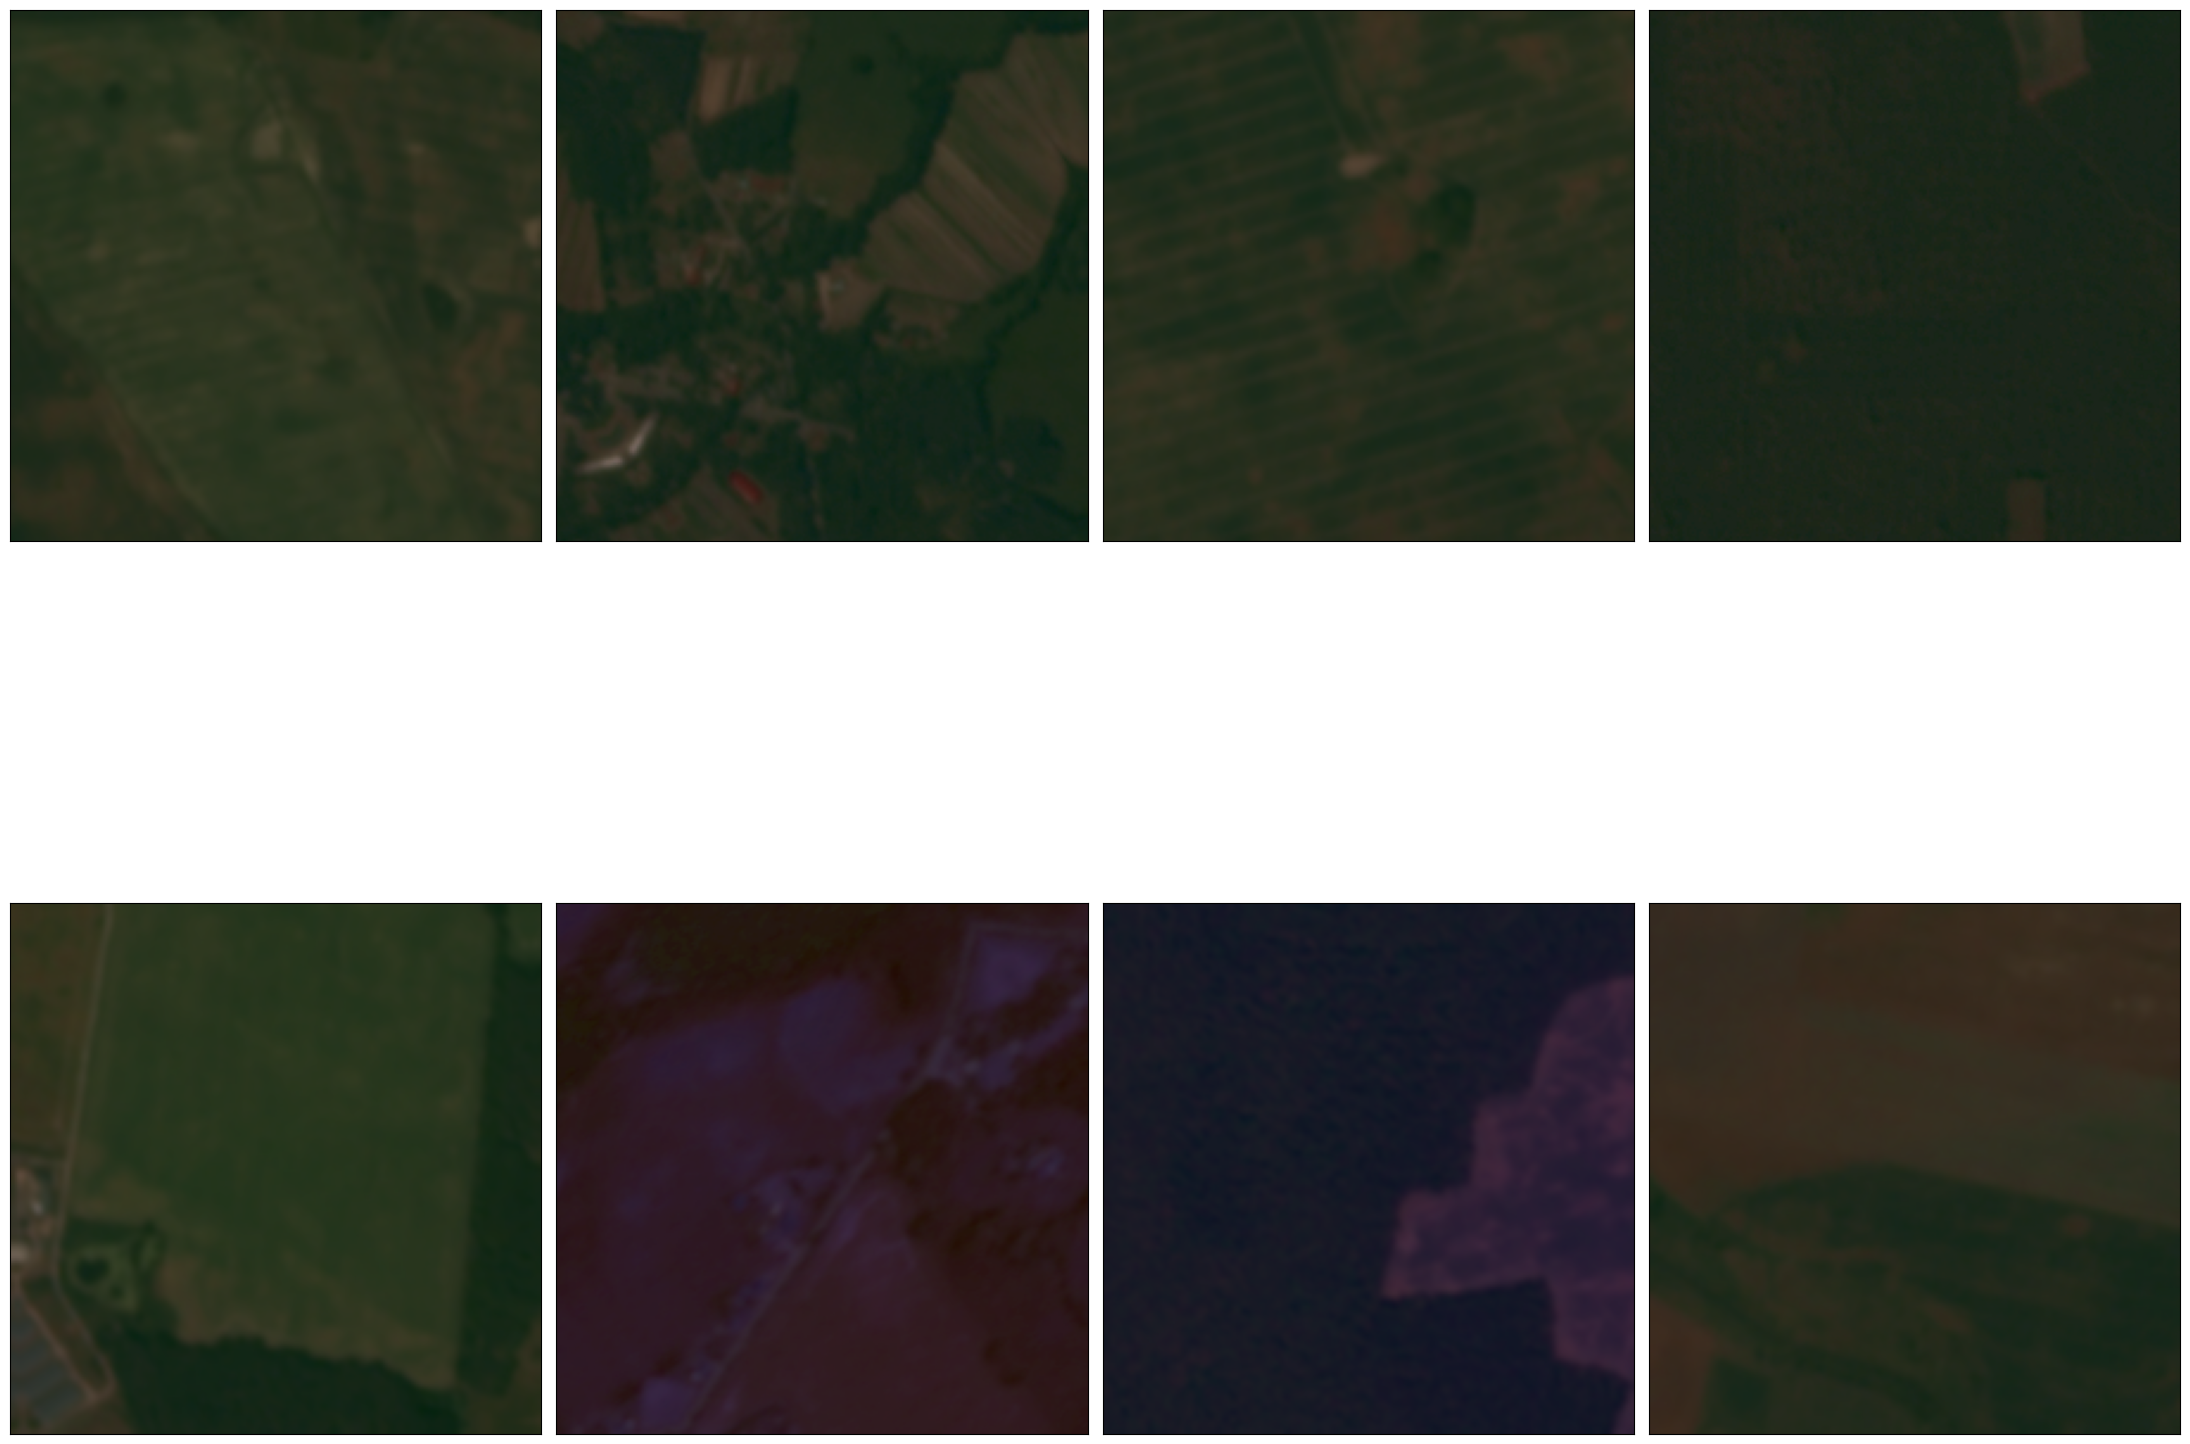

In [ ]:
view_image(train_ds)

Now that we have a variety of augmentations that will be applied to each image in each batch, let's train a model using our augmentations and pretraining.

### Display functions for monitoring model progress and visualizing arrays

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def show_predictions(image=None, mask=None, dataset=None, num=1):
  if image is None and dataset is None:
    # this is just for showing keras callback output. in practice this should be broken out into a different function
    sample_image = skio.imread(f'{img_dir}/tile_dlr_fusion_competition_germany_train_source_planet_5day_33N_18E_242N_2018_05_28_811.png') * (1/255.)
    sample_mask = skio.imread(f'{label_dir}/tile_dlr_fusion_competition_germany_train_source_planet_5day_33N_18E_242N_2018_05_28_811.png')
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask[..., tf.newaxis], mpe])
  elif dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([image, mask, mpe])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    DisplayCallback()
]

We'll use the `segmentation_models` implementation of a U-net, since it handles downlaoding pretrained weights from a variety of sources. To set up the U-Net in a manner that is equivalent with the U-Net we made from scratch in episode 3, we need to specify the correct activation function for multi-category pixel segmentation,`softmax`, and the correct number of classes: 10.

In [ ]:
# define model

sm.set_framework('tf.keras')

sm.framework()

model = sm.Unet('mobilenetv2', activation='softmax', classes = 10, encoder_weights="imagenet", input_shape=(224,224,3))

We'll compile our model with the same optimizer, loss function, and accuracy metrics from Lesson 3.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True), #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', sm.metrics.iou_score])

EPOCHS=4
model_history = model.fit(
   train_ds,
   epochs=EPOCHS,
   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
   validation_data=val_ds,
   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
   callbacks=callbacks
)

And we can view the model's loss plot and compare to Lesson 3. Was there an improvement?

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.legend()
plt.show()